In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('./sales_data_sample.csv', encoding='unicode_escape')
df.head
df.info
#Columns to Remove
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)
#Check for null values
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [9]:
#Bhai bhai look at territory
#But territory does not have significant impact on analysis, let it be 
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [10]:
#ORDERDATE Should be in date time
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

#We need to create some features in order to create cluseters
#Recency: Number of days between customer's latest order and today's date
#Frequency : Number of purchases by the customers
#MonetaryValue : Revenue generated by the customers
import datetime as dt
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days = 1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE' : lambda x : (snapshot_date - x.max()).days,
    'ORDERNUMBER' : 'count',
    'SALES' : 'sum'
})

#Rename the columns
df_RFM.rename(columns = {
    'ORDERDATE' : 'Recency',
    'ORDERNUMBER' : 'Frequency',
    'SALES' : 'MonetaryValue'
}, inplace=True)
df_RFM.head()


# Divide into segments
# We create 4 quartile ranges
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q = 4, labels = range(1,5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q = 4, labels = list(range(4,0,-1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q = 4, labels = range(1,5))

df_RFM.head()

#Create another column for RFM score
df_RFM['RFM_Score'] = df_RFM[['R', 'M', 'F']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10
Alpha Cognac,65,20,70488.44,2,4,2,8
Amica Models & Co.,265,26,94117.26,3,1,2,6
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11
Atelier graphique,188,7,24179.96,1,2,1,4


c:\Users\Abhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


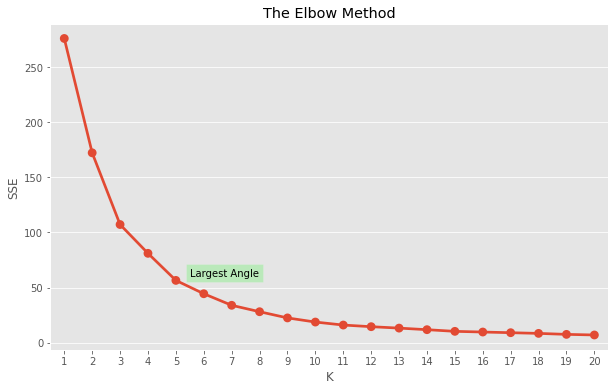

In [11]:
def rfm_level(df):
    if bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    
    elif bool(df['RFM_Score'] < 10) and bool(df['RFM_Score'] >= 6):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)
df_RFM.head()

# Time to perform KMeans
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]
data.head()
# Our data is skewed we must remove it by performing log transformation
data_log = np.log(data)
data_log.head()
#Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)



#Fit KMeans and use elbow method to choose the number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 21):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
    
    
    
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')

plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
plt.show()


In [12]:
from sklearn.cluster import KMeans
# 5 number of clusters seems good
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm = data.assign(Cluster = cluster_labels)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2
